In [1]:
import sys, cv2, os, re
sys.path.append('../')

from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from fddb_reader import *
from equi_augmentation import *
from utils import *
figsize(12, 5)

np.random.seed(42)

In [2]:
folds = get_files_folder('../data/FDDB-folds', lambda x: x.endswith('ellipseList.txt'))
folds = [x.replace('\\','/') for x in folds]

In [3]:
backs = [cv2.imread(url) for url in get_files_folder('../data/equi_backs', is_image)] ## background

In [ ]:
dataset_path = "../data/dataset_360"

#os.mkdir(dataset_path)  
for fold in folds:
    x = re.findall('FDDB-fold-\d\d', fold)[0]
    path_fold = os.path.join(dataset_path, x)
    #print(path_fold)
    images = read_fold(fold)
    
    vec = np.random.choice(7, len(images), p=[0.05,0.18, 0.18, 0.18, 0.18, 0.18, 0.05]) #defines the vertical position
    back_inds = np.random.choice(len(backs), len(images)) #defines the index of the background image
    
    #os.mkdir(path_fold)    
    for image, pos, back_i in tqdm(zip(images, vec, back_inds), total = len(images)):
        proj_path = image['path'].replace('/', '_')+'.jpg'
        proj_path = os.path.join(path_fold, proj_path)
        
        base_phi = -90+pos*30 #-90 to 90
        
        if abs(base_phi) != 90:
            phi = np.random.randint(base_phi-15, base_phi+15)
        elif base_phi == -90:
            phi = np.random.randint(base_phi, base_phi+15)
        else:
            phi = np.random.randint(base_phi-15, base_phi+1)
        
        theta = np.random.randint(-180, 181)
        r_h=1
        proj, faces_points = project_fddb_to_equi(image, backs[back_i].copy(), np.radians(phi), np.radians(theta), r_h)
        
        lines = []
        lines.append(f'{phi} {theta} {r_h}\n')
        lines.append(proj_path+'\n')
        lines.append(str(len(faces_points))+'\n')
        for face_points in faces_points:
            lines.append(str(face_points)+'\n')
            
        f = open(proj_path.replace('jpg','txt'), "a")
        f.writelines(lines)
        f.close()
        
        #print(proj_path)
        #print(phi, theta)


In [4]:
images = read_fold("../data/FDDB-folds/FDDB-fold-10-ellipseList.txt")

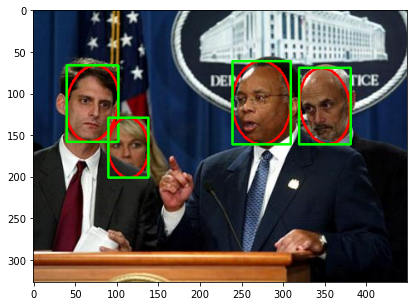

In [5]:
image = draw_image(images[218], draw_faces = True)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
def project_fddb_to_equi(image_data, back, phi, theta, r_h = 1, draw_faces = False):
    
    image = draw_image(image_data, draw_faces = False)
    
    #print(image_data)
    
    projected, _, projector = image_projection_to_equi(back, image, phi, theta, r_h = r_h)
    proj_path = image_data['path'].replace('/', '_')+'.jpg'
    
    projected_faces = projected.copy()
    
    faces_points = []
    for face in image_data['faces']:
        
        projected_pointsy_x = projector(get8boundingpointsy_x(face['bounding_box']))
        projected_points = [(p[1],p[0]) for p in projected_pointsy_x]
        faces_points.append(projected_points)
        
        t_left, t_center, t_right, c_left, c_right, b_left, b_center, b_right = projected_points
        
        projected_faces = draw_points(projected_faces, projected_points, color = (255,0,0))
   
    if draw_faces:
        plt.imshow(cv2.cvtColor(projected_faces, cv2.COLOR_BGR2RGB))
        plt.show()
        
    return projected, faces_points

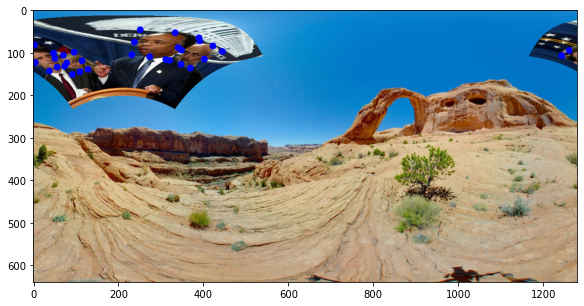

In [11]:
back = cv2.imread("../data/equi_backs/image (9).JPG", cv2.IMREAD_COLOR)

proj, faces_points = project_fddb_to_equi(images[218], back.copy(), np.radians(-60), np.radians(120), draw_faces = True)

In [9]:
##projection -60 to 60 - aproximatedely the same amount of images in each position [-60, -30, 0, 30, 60] - +-2000 range 15

##10%